In [1]:
# Read in the data
import pandas as pd
import numpy as np

df = (pd.read_csv('data/data_2.csv', parse_dates=['Time'])
     .set_index('Time')
     )
df

,Usage
Time,
2022-01-10 00:00:00,0.45
2022-01-10 00:15:00,0.02
2022-01-10 00:30:00,0.02
2022-01-10 00:45:00,0.09
2022-01-10 01:00:00,0.10
...,...
2023-05-31 22:45:00,0.35
2023-05-31 23:00:00,0.24
2023-05-31 23:15:00,0.04


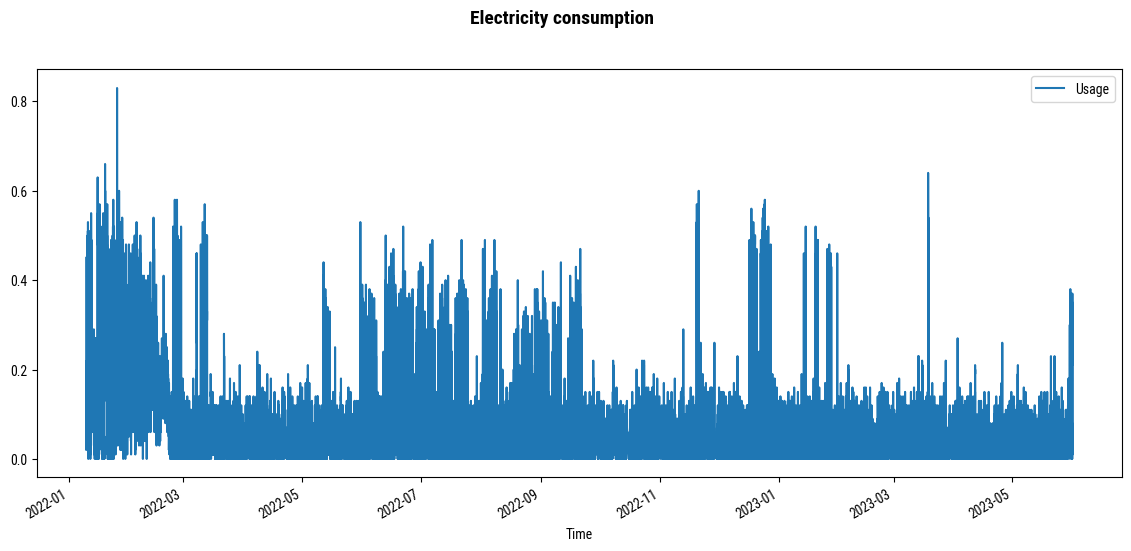

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Roboto Condensed'

# Plot the data
fig, ax = plt.subplots(figsize=(14, 6))
df.plot(ax=ax)
fig.suptitle('Electricity consumption', fontsize=14, fontweight='bold');

<Axes: ylabel='Frequency'>

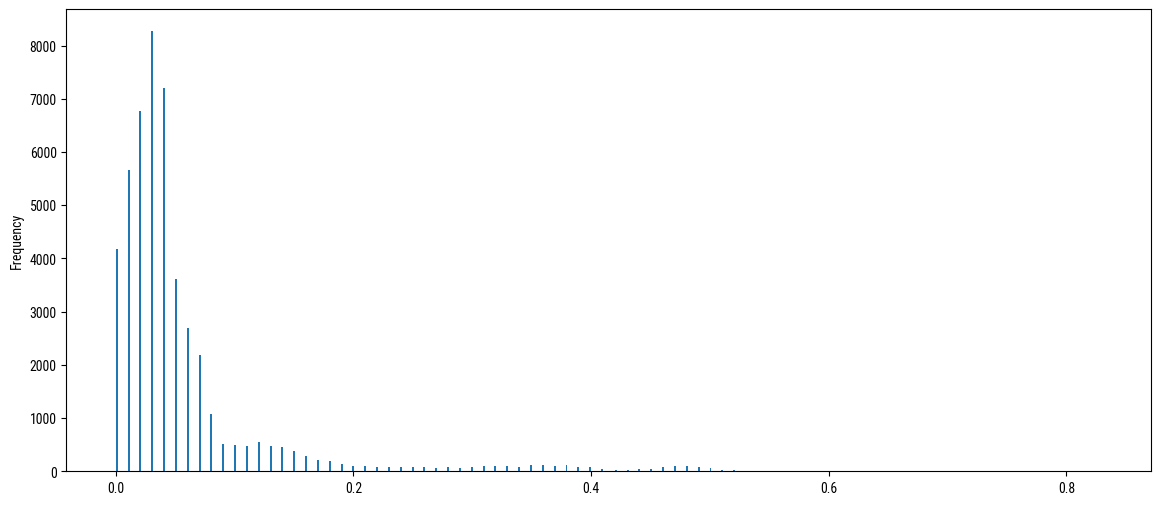

In [8]:
## Outlier detection
fig, ax = plt.subplots(figsize=(14, 6))
(df
 .Usage
 .plot.hist(ax=ax, bins=500)
)

<Axes: >

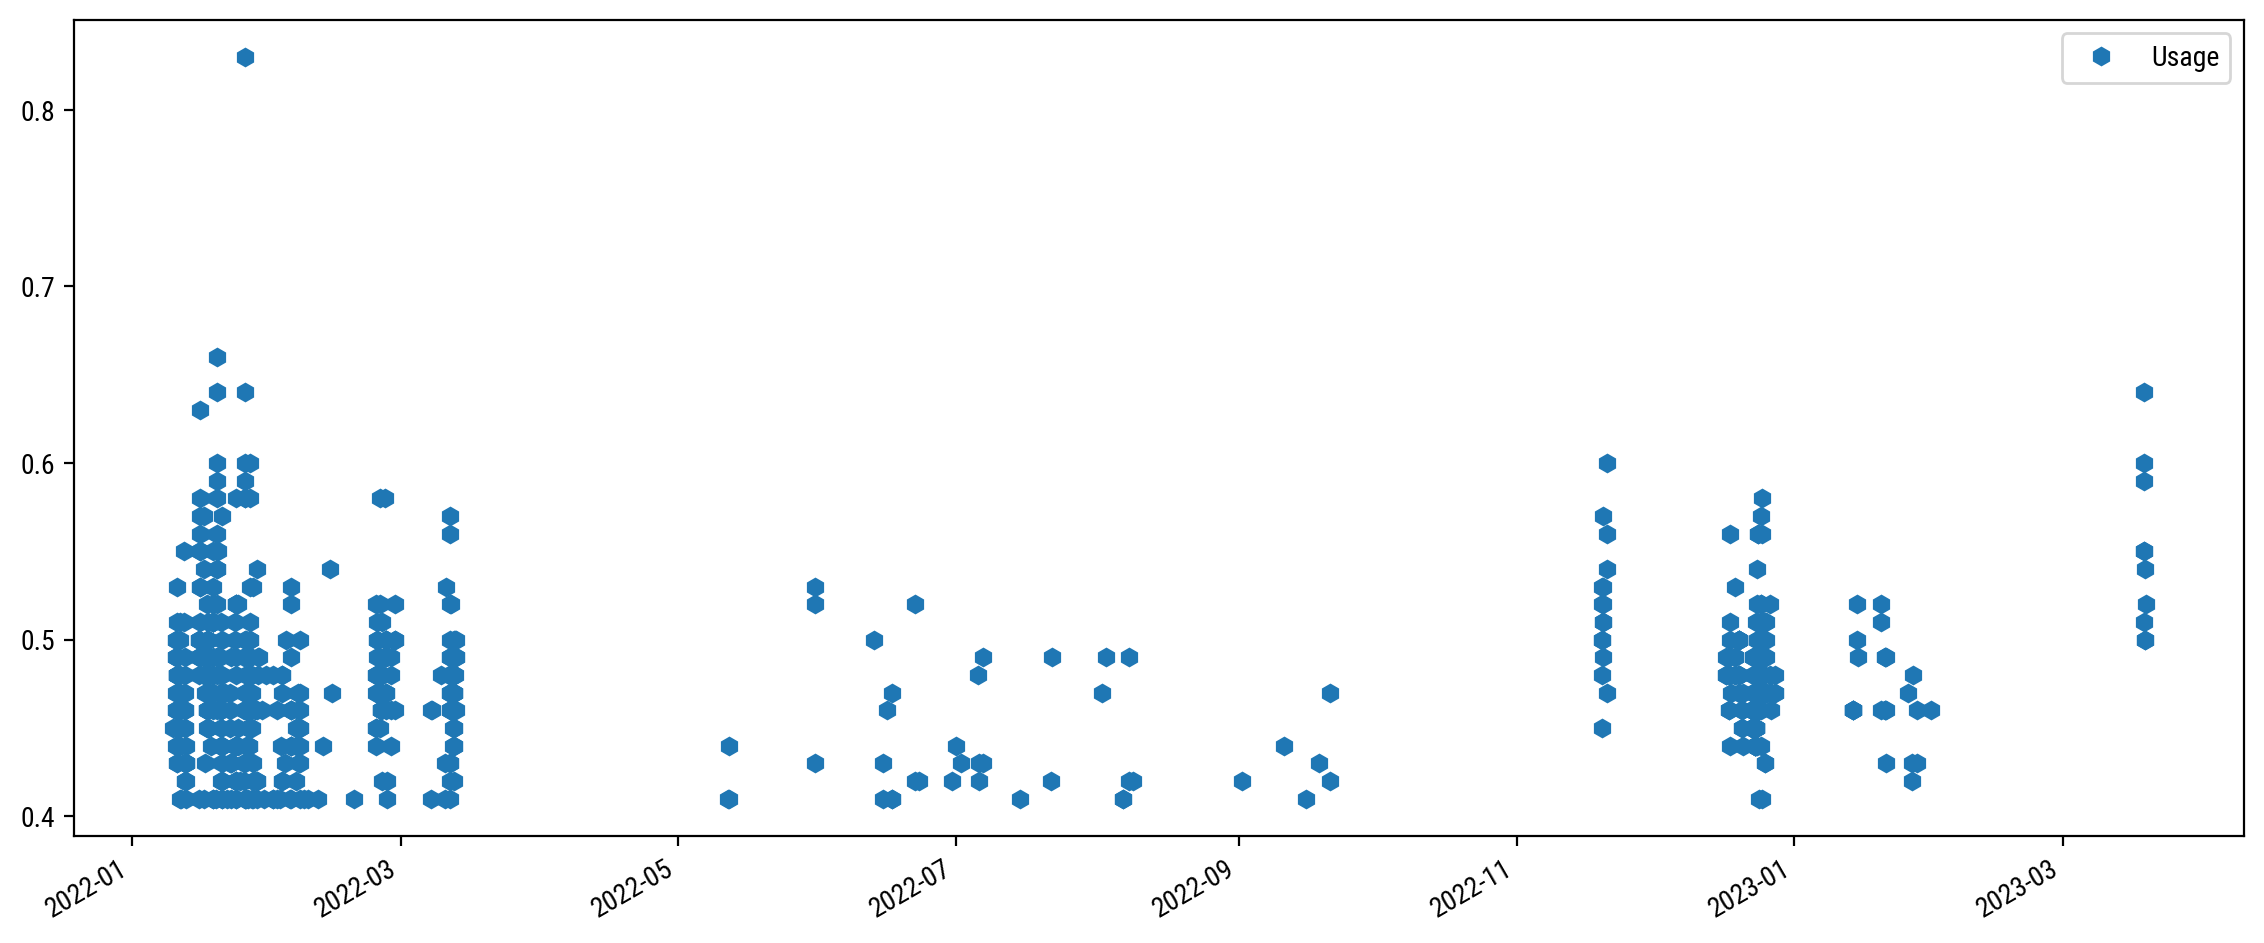

In [19]:
# Check were values are less than 0.4
fig, ax = plt.subplots(figsize=(14, 6), dpi=200)
(df
 .loc[df.Usage > 0.4]
 .plot(style='h', ax=ax, xlabel='')
 )

In [20]:
outlier_df = df.loc[df.Usage < 0.4]

## Time series cross validation

In [28]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5,
                      test_size=24*7, # predict one week
                      gap=24*2 # 2 day gap between train and test
                      )
df = df.sort_index()


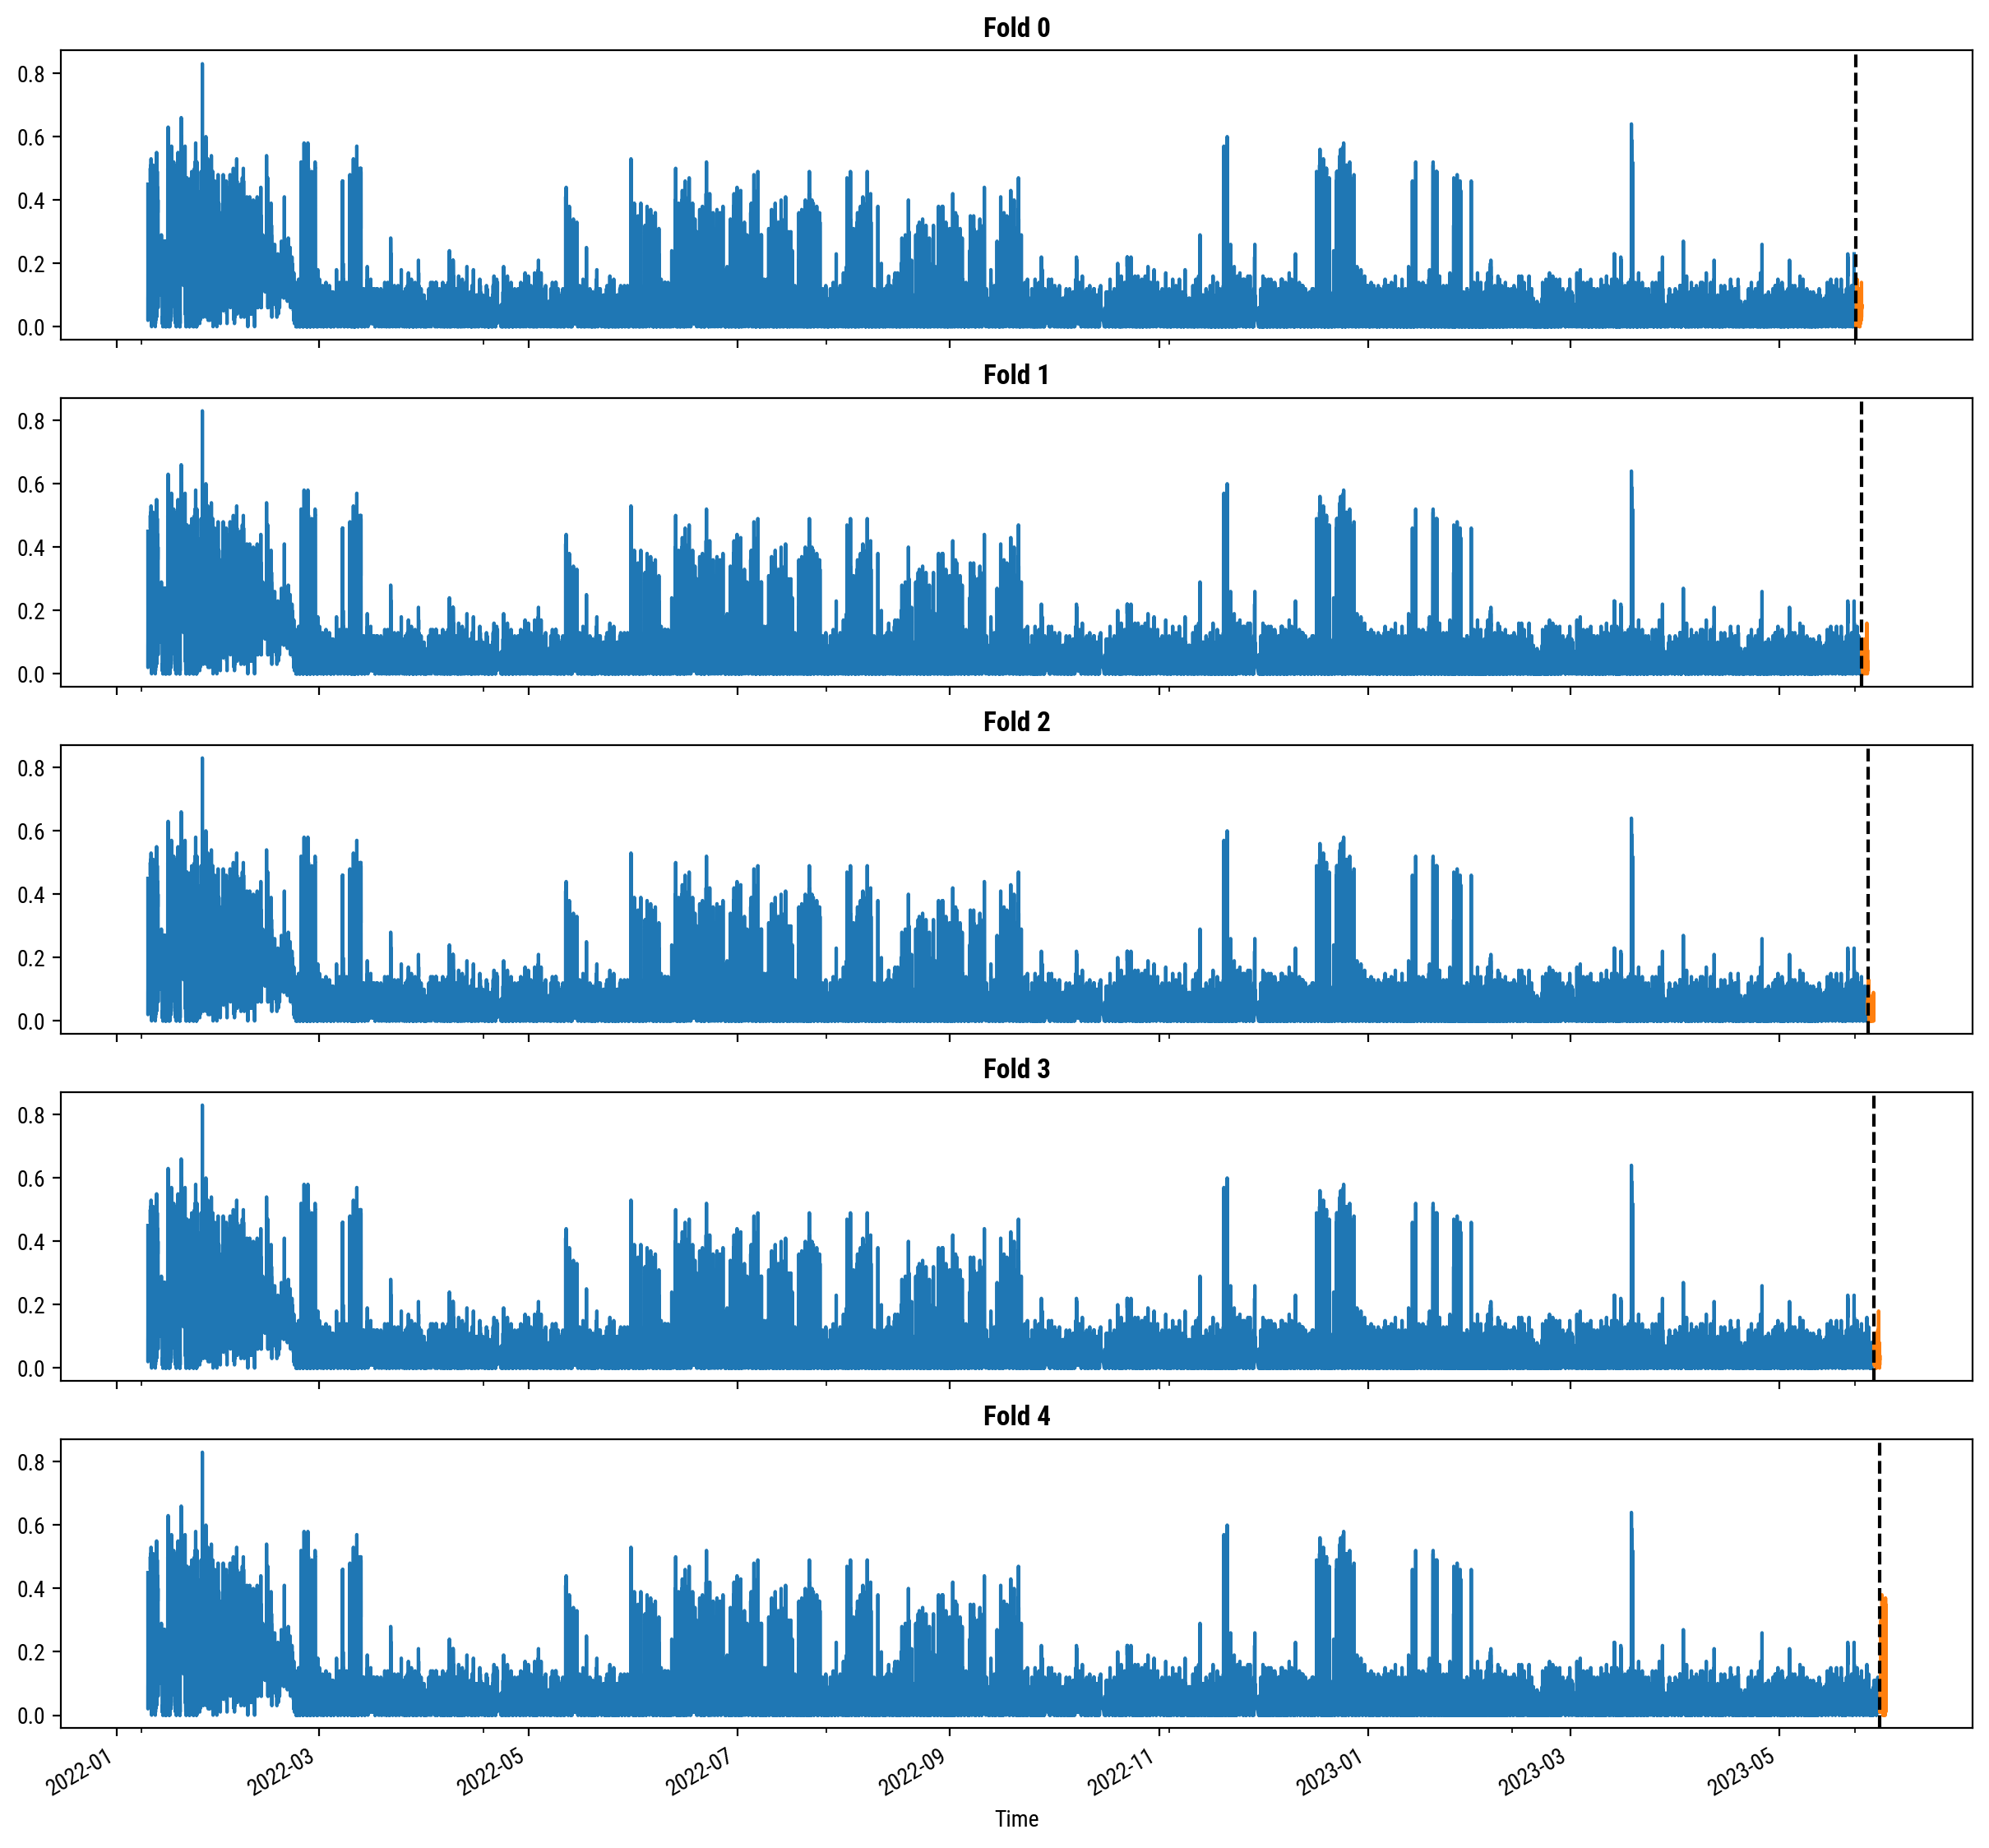

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 1, figsize=(15, 15), dpi=200, sharex=True)

fold = 0
for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    train_plot = train.Usage.plot(ax=ax[fold], label='train')
    test.Usage.plot(ax=ax[fold], label='test')
    ax[fold].axvline(test.index.min(), color='k', linestyle='--')
    ax[fold].set_title(f'Fold {fold}', fontsize=12, fontweight='bold')
    fold += 1


## Forecasting horizon
The forecasting horizon is the number of time steps we want to predict into the future. In this case, we want to predict 1 week into the future, so the forecasting horizon is 7 days.

In [42]:
def create_cols(df):
    """Create time series cols based on time series index"""
    return (df
    .assign(hour=lambda df_: df_.index.hour,
            dayofweek=lambda df_: df_.index.dayofweek,
            quarter=lambda df_: df_.index.quarter,
            month=lambda df_: df_.index.month,
            year=lambda df_: df_.index.year,
            dayofyear=lambda df_: df_.index.dayofyear)
    )

df = create_cols(df)

In [44]:
## Lag features
def create_lag_features(df, lags, col):
    """Create lag features for a given column"""
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

In [47]:
gg = (df
 .pipe(create_lag_features, lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], col='Usage')
#  .tail(10)
 )

In [48]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

tss = TimeSeriesSplit(n_splits=5,
                      test_size=24*7, # predict one week
                      gap=24*2)
gg = gg.sort_index()

fold = 0
predictions = []
scores = []
for train_index, val_index in tss.split(df):
    train = gg.iloc[train_index]
    test = gg.iloc[val_index]

    train = create_cols(train)
    test = create_cols(test)

    # Partition features and target
    FEATURES = gg.iloc[:, 1:].columns
    TARGET = gg.iloc[:, [0]].columns

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    # Predict
    y_pred = reg.predict(X_test)
    predictions.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[21:55:43] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.44595	validation_1-rmse:0.45038
[100]	validation_0-rmse:0.16754	validation_1-rmse:0.16530
[200]	validation_0-rmse:0.07129	validation_1-rmse:0.06337
[300]	validation_0-rmse:0.04429	validation_1-rmse:0.03098
[400]	validation_0-rmse:0.03898	validation_1-rmse:0.02365
[500]	validation_0-rmse:0.03794	validation_1-rmse:0.02278
[600]	validation_0-rmse:0.03764	validation_1-rmse:0.02276
[604]	validation_0-rmse:0.03763	validation_1-rmse:0.02276
[21:55:55] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.44596	validation_1-rmse:0.45471
[100]	validation_0-rmse:0.16753	validation_1-rmse:0.16717
[200]	validation_0-rmse:0.07127	validation_1-rmse:0.06326
[300]	validation

In [52]:
print(f'Average score across folds: {np.mean(scores)}')
print(f'Fold scores: {scores}')

Average score across folds: 0.028249056546589407
Fold scores: [0.02273925584978658, 0.019019138198089452, 0.018534644930990687, 0.023520819430990055, 0.057431424323090265]


In [ ]:
# Train model on entire dataset
df_all = df

# Partition features and target
FEATURES = df_all.iloc[:, 1:].columns
TARGET = df_all.iloc[:, [0]].columns

X_all, y_all = df_all[FEATURES], df_all[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                        booster='gbtree',
                        n_estimators=600, # from cross validation, overfitting after 600
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01)

In [9]:
# The data is right skewed, so we will use the median and median absolute deviation (MAD) to detect outliers
median = df.Usage.median()
mad = df.Usage.mad()
median, mad


C:\Users\mutej\AppData\Local\Temp\ipykernel_1196\1278829772.py:3: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.Usage.mad()


(0.03, 0.04628076903677433)

In [10]:
median

0.03